In [1]:
from pathlib import Path
import random
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.utils import class_weight
from joblib import dump, load
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Nadam
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import librosa.display
import soundfile as sf

if len(tf.config.list_physical_devices('GPU')) != 0:
    print('TF_DETERMINISTIC_OPS => 1')
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

TF_DETERMINISTIC_OPS => 1


2022-08-27 01:03:51.367665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 01:03:51.413090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 01:03:51.413807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 特徴量作成

In [12]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

In [13]:
y_train, y_val, y_test = train_df['disease'], val_df['disease'], test_df['disease']

In [15]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)
dump(le, './label_encoder.joblib')

['./label_encoder.joblib']

In [3]:
ROOT_DIR = '../dataset/preprocessed_audio_files/'


def get_features(path):
    sound_arr, sample_rate = lb.load(path)
    mfcc = lb.feature.mfcc(y=sound_arr, sr=sample_rate)
    chroma_stft = lb.feature.chroma_stft(y=sound_arr, sr=sample_rate)
    mel_spectrogram = lb.feature.melspectrogram(y=sound_arr, sr=sample_rate)
    return mfcc, chroma_stft, mel_spectrogram


def get_dataset(df: pd.DataFrame, root_path=ROOT_DIR):
    mfcc_ds, chroma_stft_ds, mel_spectrogram_ds = [], [], []
    for idx, row in df.iterrows():
        src = Path(root_path) / row['filename']
        mfcc, chroma_stft, mel_spectrogram = get_features(src)
        mfcc_ds.append(mfcc)
        chroma_stft_ds.append(chroma_stft)
        mel_spectrogram_ds.append(mel_spectrogram)
    return np.array(mfcc_ds), np.array(chroma_stft_ds), np.array(mel_spectrogram_ds)


def save_to_npy(dst, mfcc, chroma_stft, mel_spectrogram, label):
    assert len(mfcc) == len(chroma_stft) == len(mel_spectrogram) == len(label)
    np.save(dst, {'x': {'mfcc': mfcc, 'chroma': chroma_stft, 'mspec': mel_spectrogram}, 'y': label})


def load_npy(src):
    data = np.load(src, allow_pickle=True)[()]
    return data['x'], data['y']

In [13]:
train_mfcc, train_chroma_stft, train_mel_spectrogram = get_dataset(train_df)
val_mfcc, val_chroma_stft, val_mel_spectrogram = get_dataset(val_df)
test_mfcc, test_chroma_stft, test_mel_spectrogram = get_dataset(test_df)

/usr/local/lib/python3.8/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [28]:
dst_dir = Path('../dataset//features')
dst_dir.mkdir(exist_ok=True)
save_to_npy(str(dst_dir / 'train.npy'), train_mfcc, train_chroma_stft, train_mel_spectrogram, y_train)
save_to_npy(str(dst_dir / 'val.npy'), val_mfcc, val_chroma_stft, val_mel_spectrogram, y_val)
save_to_npy(str(dst_dir / 'test.npy'), test_mfcc, test_chroma_stft, test_mel_spectrogram, y_test)

In [25]:
print(train_mfcc.shape, train_chroma_stft.shape, train_mel_spectrogram.shape)
print(val_mfcc.shape, val_chroma_stft.shape, val_mel_spectrogram.shape)
print(test_mfcc.shape, test_chroma_stft.shape, test_mel_spectrogram.shape)

(4828, 20, 259) (4828, 12, 259) (4828, 128, 259)
(1035, 20, 259) (1035, 12, 259) (1035, 128, 259)
(1035, 20, 259) (1035, 12, 259) (1035, 128, 259)


## モデル作成

In [7]:
def conv_block(x, filters, kernel_size, strides=(1, 1), conv_padding='same'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=conv_padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    return x


def get_model():
    # mfcc入力
    mfcc_input = layers.Input(shape=(20, 259, 1), name='mfcc')
    mfcc = conv_block(mfcc_input, filters=32, kernel_size=5, strides=(1, 3))
    mfcc = conv_block(mfcc, filters=64, kernel_size=3, strides=(1, 2))
    mfcc = conv_block(mfcc, filters=96, kernel_size=2)
    mfcc = conv_block(mfcc, filters=128, kernel_size=2)
    mfcc_output = layers.GlobalMaxPooling2D()(mfcc)

    # chroma sftf入力
    chroma_input = layers.Input(shape=(12, 259, 1), name='chroma')
    chroma = conv_block(chroma_input, filters=32, kernel_size=5, strides=(1, 3))
    chroma = conv_block(chroma, filters=64, kernel_size=3, strides=(1, 2))
    chroma = conv_block(chroma, filters=128, kernel_size=2)
    chroma_output = layers.GlobalMaxPooling2D()(chroma)

    # melspectrogram入力
    mel_spec_input = layers.Input(shape=(128, 259, 1), name='mspec')
    mel_spec = conv_block(mel_spec_input, filters=32, kernel_size=5, strides=(2, 3))
    mel_spec = conv_block(mel_spec, filters=64, kernel_size=3, strides=(2, 2))
    mel_spec = conv_block(mel_spec, filters=96, kernel_size=2)
    mel_spec = conv_block(mel_spec, filters=128, kernel_size=2)
    mel_spec_output = layers.GlobalMaxPooling2D()(mel_spec)

    # 出力の結合
    concat = layers.concatenate([mfcc_output, chroma_output, mel_spec_output])
    dense = layers.Dense(50, activation='relu')(concat)
    dense = layers.Dropout(.3)(dense)
    dense = layers.Dense(25, activation='relu')(dense)
    dense = layers.Dropout(.3)(dense)
    output = layers.Dense(8, activation='softmax')(dense)
    model = keras.Model([mfcc_input, chroma_input, mel_spec_input], output, name='net')
    return model


def fix_seed(seed=42):
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [8]:
fix_seed()
model = get_model()
model.summary()

Model: "net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 20, 87, 32)   832         ['mfcc[0][0]']                   
                                                                                                

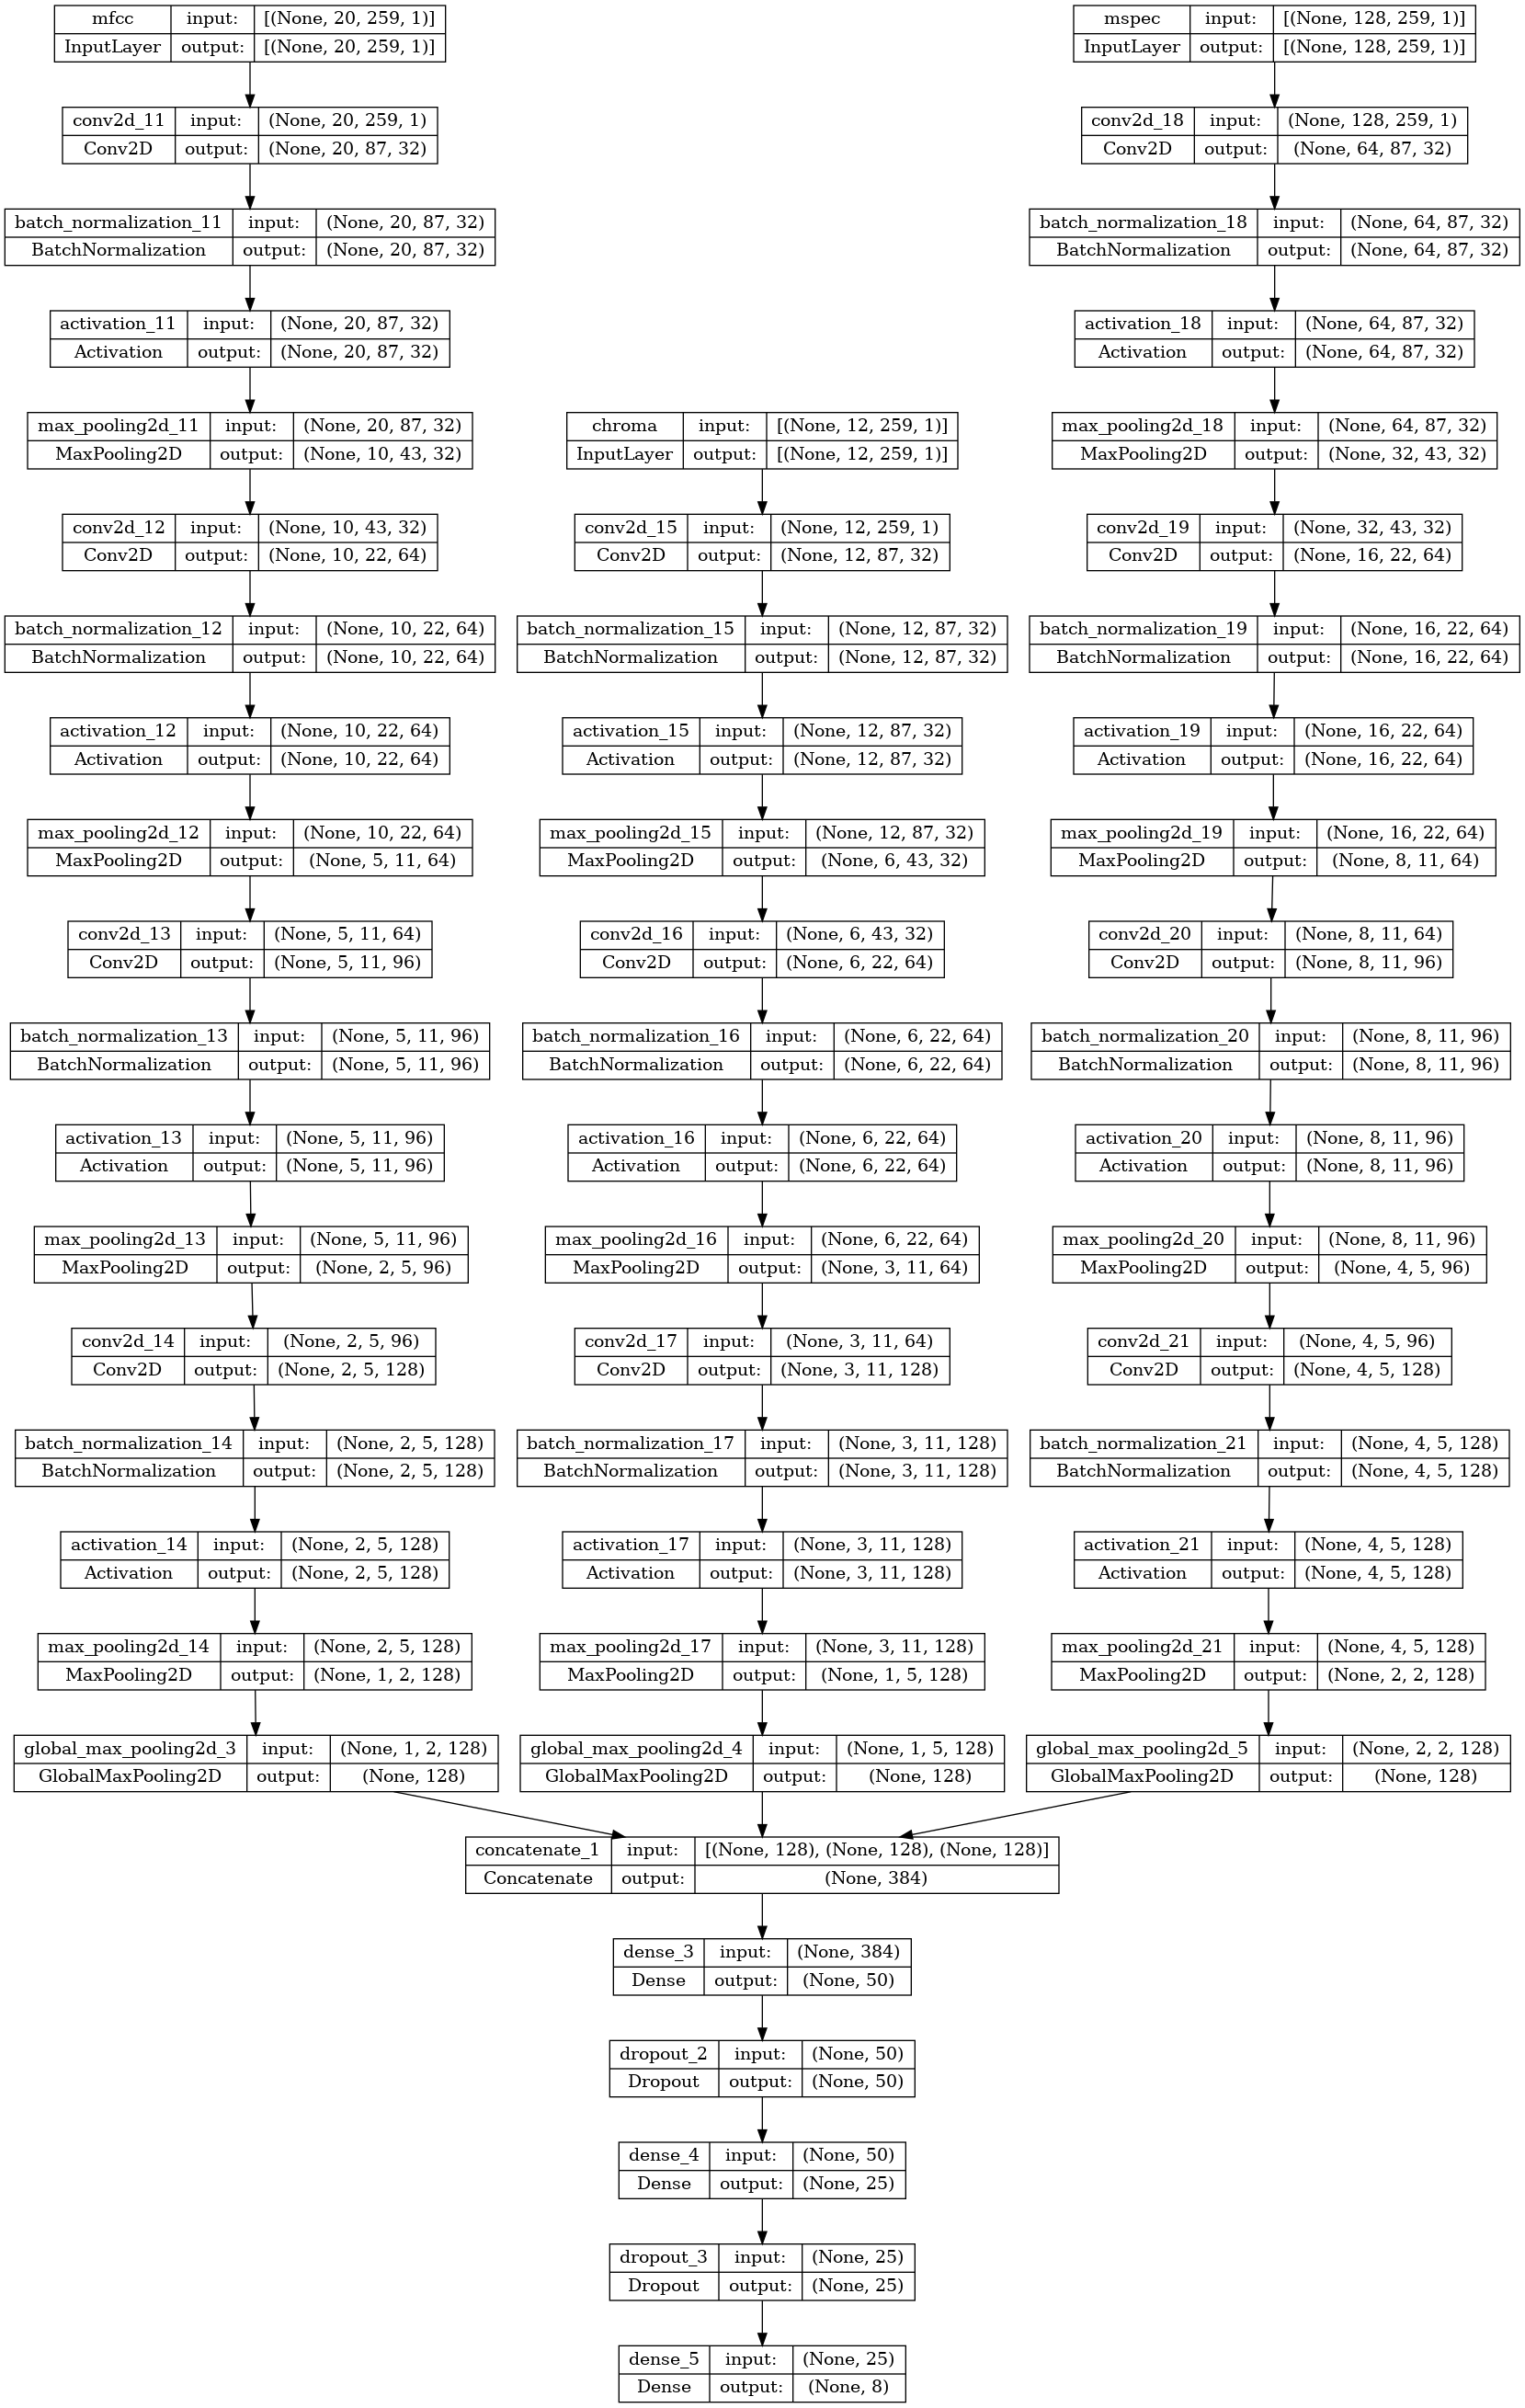

In [18]:
keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [9]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=50),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=0.0001,
        mode='min'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'checkpoint',
        monitor='val_loss',
        save_best_only=True
    )
]
SEED = 42
EPOCHS = 300
fix_seed(SEED)
model = get_model()
model.compile(loss='sparse_categorical_crossentropy', optimizer=Nadam(learning_rate=0.001), metrics=['accuracy'])
X_train, y_train = load_npy('../dataset/features/train.npy')
X_val, y_val = load_npy('../dataset/features/val.npy')
X_test, y_test = load_npy('../dataset/features/test.npy')
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {i: weight for i, weight in enumerate(weights)}
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    verbose=1,
    class_weight=weights,
    callbacks=callbacks
)

Epoch 1/300


2022-08-27 01:05:39.307786: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


151/151 [==============================] - ETA: 0s - loss: 2.0532 - accuracy: 0.4285

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 13s 43ms/step - loss: 2.0532 - accuracy: 0.4285 - val_loss: 1.2547 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 2/300
151/151 [==============================] - 3s 19ms/step - loss: 2.1811 - accuracy: 0.3268 - val_loss: 1.3827 - val_accuracy: 0.4986 - lr: 0.0010
Epoch 3/300
151/151 [==============================] - 3s 21ms/step - loss: 2.0513 - accuracy: 0.3925 - val_loss: 1.5060 - val_accuracy: 0.1758 - lr: 0.0010
Epoch 4/300
151/151 [==============================] - 3s 20ms/step - loss: 1.9882 - accuracy: 0.3788 - val_loss: 1.3705 - val_accuracy: 0.5488 - lr: 0.0010
Epoch 5/300
151/151 [==============================] - 3s 20ms/step - loss: 1.7995 - accuracy: 0.4039 - val_loss: 1.3240 - val_accuracy: 0.5845 - lr: 1.0000e-04
Epoch 6/300
151/151 [==============================] - 3s 20ms/step - loss: 1.9002 - accuracy: 0.3703 - val_loss: 1.4388 - val_accuracy: 0.3623 - lr: 1.0000e-04
Epoch 7/300
151/151 [==============================] - 3s 20m

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 40ms/step - loss: 1.7738 - accuracy: 0.4774 - val_loss: 1.2275 - val_accuracy: 0.5633 - lr: 1.0000e-04
Epoch 17/300
151/151 [==============================] - 3s 19ms/step - loss: 1.6680 - accuracy: 0.5052 - val_loss: 1.2302 - val_accuracy: 0.5150 - lr: 1.0000e-04
Epoch 18/300
151/151 [==============================] - 3s 19ms/step - loss: 1.6971 - accuracy: 0.4944 - val_loss: 1.2451 - val_accuracy: 0.4995 - lr: 1.0000e-04
Epoch 19/300
150/151 [============================>.] - ETA: 0s - loss: 1.7292 - accuracy: 0.5296

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 39ms/step - loss: 1.7278 - accuracy: 0.5302 - val_loss: 1.0851 - val_accuracy: 0.6570 - lr: 1.0000e-04
Epoch 20/300
151/151 [==============================] - ETA: 0s - loss: 1.5809 - accuracy: 0.5822

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 1.5809 - accuracy: 0.5822 - val_loss: 0.9949 - val_accuracy: 0.6995 - lr: 1.0000e-04
Epoch 21/300
151/151 [==============================] - 3s 18ms/step - loss: 1.6744 - accuracy: 0.5327 - val_loss: 1.0066 - val_accuracy: 0.6918 - lr: 1.0000e-04
Epoch 22/300
151/151 [==============================] - 3s 20ms/step - loss: 1.7093 - accuracy: 0.5901 - val_loss: 1.2010 - val_accuracy: 0.5681 - lr: 1.0000e-04
Epoch 23/300
151/151 [==============================] - 3s 20ms/step - loss: 1.5546 - accuracy: 0.5984 - val_loss: 1.0025 - val_accuracy: 0.6841 - lr: 1.0000e-04
Epoch 24/300
150/151 [============================>.] - ETA: 0s - loss: 1.6357 - accuracy: 0.6190

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 39ms/step - loss: 1.6296 - accuracy: 0.6193 - val_loss: 0.8473 - val_accuracy: 0.7536 - lr: 1.0000e-04
Epoch 25/300
151/151 [==============================] - ETA: 0s - loss: 1.5332 - accuracy: 0.6448

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 40ms/step - loss: 1.5332 - accuracy: 0.6448 - val_loss: 0.8310 - val_accuracy: 0.7536 - lr: 1.0000e-04
Epoch 26/300
148/151 [============================>.] - ETA: 0s - loss: 1.5099 - accuracy: 0.6734

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 1.5153 - accuracy: 0.6740 - val_loss: 0.7882 - val_accuracy: 0.7758 - lr: 1.0000e-04
Epoch 27/300
151/151 [==============================] - 3s 19ms/step - loss: 1.5397 - accuracy: 0.6179 - val_loss: 0.8797 - val_accuracy: 0.7227 - lr: 1.0000e-04
Epoch 28/300
149/151 [============================>.] - ETA: 0s - loss: 1.4720 - accuracy: 0.6059

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 39ms/step - loss: 1.4889 - accuracy: 0.6052 - val_loss: 0.7407 - val_accuracy: 0.8029 - lr: 1.0000e-04
Epoch 29/300
151/151 [==============================] - 3s 20ms/step - loss: 1.2873 - accuracy: 0.6500 - val_loss: 0.8792 - val_accuracy: 0.7256 - lr: 1.0000e-04
Epoch 30/300
151/151 [==============================] - 3s 18ms/step - loss: 1.2863 - accuracy: 0.6520 - val_loss: 0.9180 - val_accuracy: 0.6889 - lr: 1.0000e-04
Epoch 31/300
151/151 [==============================] - 3s 20ms/step - loss: 1.4007 - accuracy: 0.6775 - val_loss: 0.9830 - val_accuracy: 0.6512 - lr: 1.0000e-04
Epoch 32/300
151/151 [==============================] - 3s 20ms/step - loss: 1.2909 - accuracy: 0.6711 - val_loss: 0.9186 - val_accuracy: 0.6638 - lr: 1.0000e-04
Epoch 33/300
151/151 [==============================] - 3s 19ms/step - loss: 1.2681 - accuracy: 0.6914 - val_loss: 0.7579 - val_accuracy: 0.7488 - lr: 1.0000e-04
Epoch 34/300
149/151 [===================

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 40ms/step - loss: 1.2027 - accuracy: 0.6895 - val_loss: 0.5856 - val_accuracy: 0.8048 - lr: 1.0000e-04
Epoch 35/300
151/151 [==============================] - 3s 18ms/step - loss: 1.2700 - accuracy: 0.6978 - val_loss: 1.0070 - val_accuracy: 0.6261 - lr: 1.0000e-04
Epoch 36/300
151/151 [==============================] - 3s 19ms/step - loss: 1.1446 - accuracy: 0.6939 - val_loss: 0.6424 - val_accuracy: 0.7739 - lr: 1.0000e-04
Epoch 37/300
151/151 [==============================] - 3s 19ms/step - loss: 1.1898 - accuracy: 0.6980 - val_loss: 0.7455 - val_accuracy: 0.7382 - lr: 1.0000e-04
Epoch 38/300
151/151 [==============================] - 3s 19ms/step - loss: 1.1352 - accuracy: 0.6943 - val_loss: 0.6134 - val_accuracy: 0.7826 - lr: 1.0000e-04
Epoch 39/300
151/151 [==============================] - 3s 20ms/step - loss: 1.3360 - accuracy: 0.6953 - val_loss: 0.6352 - val_accuracy: 0.7729 - lr: 1.0000e-04
Epoch 40/300
151/151 [===================

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 1.0480 - accuracy: 0.7245 - val_loss: 0.4952 - val_accuracy: 0.8242 - lr: 1.0000e-04
Epoch 42/300
151/151 [==============================] - 3s 19ms/step - loss: 1.0021 - accuracy: 0.7318 - val_loss: 0.5194 - val_accuracy: 0.8126 - lr: 1.0000e-04
Epoch 43/300
151/151 [==============================] - 3s 18ms/step - loss: 0.9582 - accuracy: 0.7444 - val_loss: 0.5758 - val_accuracy: 0.7894 - lr: 1.0000e-04
Epoch 44/300
151/151 [==============================] - 3s 17ms/step - loss: 1.1823 - accuracy: 0.7496 - val_loss: 0.5629 - val_accuracy: 0.7932 - lr: 1.0000e-04
Epoch 45/300
151/151 [==============================] - 3s 17ms/step - loss: 1.0823 - accuracy: 0.7444 - val_loss: 0.7308 - val_accuracy: 0.7237 - lr: 1.0000e-04
Epoch 46/300
149/151 [============================>.] - ETA: 0s - loss: 1.0419 - accuracy: 0.7546

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 41ms/step - loss: 1.0458 - accuracy: 0.7539 - val_loss: 0.4949 - val_accuracy: 0.8126 - lr: 1.0000e-04
Epoch 47/300
151/151 [==============================] - 3s 19ms/step - loss: 0.8974 - accuracy: 0.7514 - val_loss: 0.5153 - val_accuracy: 0.8155 - lr: 1.0000e-04
Epoch 48/300
150/151 [============================>.] - ETA: 0s - loss: 1.0095 - accuracy: 0.7635

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 41ms/step - loss: 1.0074 - accuracy: 0.7633 - val_loss: 0.4530 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 49/300
151/151 [==============================] - 3s 20ms/step - loss: 0.8540 - accuracy: 0.7763 - val_loss: 0.4560 - val_accuracy: 0.8222 - lr: 1.0000e-04
Epoch 50/300
148/151 [============================>.] - ETA: 0s - loss: 0.8988 - accuracy: 0.7713

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 39ms/step - loss: 0.8957 - accuracy: 0.7724 - val_loss: 0.4414 - val_accuracy: 0.8222 - lr: 1.0000e-04
Epoch 51/300
151/151 [==============================] - 3s 17ms/step - loss: 0.8658 - accuracy: 0.7682 - val_loss: 0.5264 - val_accuracy: 0.8106 - lr: 1.0000e-04
Epoch 52/300
151/151 [==============================] - 3s 17ms/step - loss: 0.9125 - accuracy: 0.7827 - val_loss: 0.4759 - val_accuracy: 0.8280 - lr: 1.0000e-04
Epoch 53/300
151/151 [==============================] - 3s 19ms/step - loss: 0.9540 - accuracy: 0.7908 - val_loss: 0.5097 - val_accuracy: 0.8010 - lr: 1.0000e-04
Epoch 54/300
150/151 [============================>.] - ETA: 0s - loss: 0.9690 - accuracy: 0.7887

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 0.9687 - accuracy: 0.7894 - val_loss: 0.3451 - val_accuracy: 0.8802 - lr: 1.0000e-04
Epoch 55/300
151/151 [==============================] - 3s 18ms/step - loss: 0.8408 - accuracy: 0.7856 - val_loss: 0.4431 - val_accuracy: 0.8338 - lr: 1.0000e-04
Epoch 56/300
151/151 [==============================] - ETA: 0s - loss: 0.8201 - accuracy: 0.7966

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 41ms/step - loss: 0.8201 - accuracy: 0.7966 - val_loss: 0.3294 - val_accuracy: 0.8821 - lr: 1.0000e-04
Epoch 57/300
151/151 [==============================] - 3s 18ms/step - loss: 1.0247 - accuracy: 0.7494 - val_loss: 0.4296 - val_accuracy: 0.8396 - lr: 1.0000e-04
Epoch 58/300
151/151 [==============================] - 3s 18ms/step - loss: 0.9392 - accuracy: 0.7900 - val_loss: 0.4803 - val_accuracy: 0.8271 - lr: 1.0000e-04
Epoch 59/300
151/151 [==============================] - 3s 19ms/step - loss: 0.8559 - accuracy: 0.7875 - val_loss: 0.4504 - val_accuracy: 0.8280 - lr: 1.0000e-04
Epoch 60/300
151/151 [==============================] - 3s 19ms/step - loss: 0.9291 - accuracy: 0.7985 - val_loss: 0.3951 - val_accuracy: 0.8570 - lr: 1.0000e-04
Epoch 61/300
151/151 [==============================] - 3s 20ms/step - loss: 0.7683 - accuracy: 0.8080 - val_loss: 0.5234 - val_accuracy: 0.8039 - lr: 1.0000e-04
Epoch 62/300
151/151 [===================

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 0.6260 - accuracy: 0.8316 - val_loss: 0.3292 - val_accuracy: 0.8870 - lr: 1.0000e-04
Epoch 82/300
151/151 [==============================] - 3s 19ms/step - loss: 0.6551 - accuracy: 0.8329 - val_loss: 0.4394 - val_accuracy: 0.8483 - lr: 1.0000e-04
Epoch 83/300
148/151 [============================>.] - ETA: 0s - loss: 0.5393 - accuracy: 0.8511

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 39ms/step - loss: 0.5366 - accuracy: 0.8517 - val_loss: 0.3164 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 84/300
151/151 [==============================] - 3s 19ms/step - loss: 0.5445 - accuracy: 0.8511 - val_loss: 0.3212 - val_accuracy: 0.8908 - lr: 1.0000e-04
Epoch 85/300
151/151 [==============================] - 3s 19ms/step - loss: 0.6539 - accuracy: 0.8587 - val_loss: 0.4550 - val_accuracy: 0.8464 - lr: 1.0000e-04
Epoch 86/300
151/151 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.8418

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 41ms/step - loss: 0.6109 - accuracy: 0.8418 - val_loss: 0.2896 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 87/300
151/151 [==============================] - 3s 18ms/step - loss: 0.4947 - accuracy: 0.8654 - val_loss: 0.3250 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 88/300
151/151 [==============================] - 3s 20ms/step - loss: 0.4593 - accuracy: 0.8788 - val_loss: 0.3424 - val_accuracy: 0.8908 - lr: 1.0000e-04
Epoch 89/300
151/151 [==============================] - 3s 20ms/step - loss: 0.4761 - accuracy: 0.8732 - val_loss: 0.3978 - val_accuracy: 0.8647 - lr: 1.0000e-04
Epoch 90/300
151/151 [==============================] - 3s 19ms/step - loss: 0.4600 - accuracy: 0.8716 - val_loss: 0.4413 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 91/300
151/151 [==============================] - 3s 19ms/step - loss: 0.5243 - accuracy: 0.8734 - val_loss: 0.3618 - val_accuracy: 0.8841 - lr: 1.0000e-04
Epoch 92/300
151/151 [===================

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 41ms/step - loss: 0.4846 - accuracy: 0.8778 - val_loss: 0.2878 - val_accuracy: 0.9043 - lr: 1.0000e-04
Epoch 94/300
151/151 [==============================] - 3s 18ms/step - loss: 0.5022 - accuracy: 0.8757 - val_loss: 0.3094 - val_accuracy: 0.9024 - lr: 1.0000e-04
Epoch 95/300
151/151 [==============================] - 3s 21ms/step - loss: 0.5954 - accuracy: 0.8908 - val_loss: 0.3429 - val_accuracy: 0.8831 - lr: 1.0000e-04
Epoch 96/300
151/151 [==============================] - 3s 21ms/step - loss: 0.6292 - accuracy: 0.8596 - val_loss: 0.3501 - val_accuracy: 0.8792 - lr: 1.0000e-04
Epoch 97/300
151/151 [==============================] - 3s 20ms/step - loss: 0.5252 - accuracy: 0.8598 - val_loss: 0.3367 - val_accuracy: 0.8899 - lr: 1.0000e-04
Epoch 98/300
151/151 [==============================] - 3s 19ms/step - loss: 0.4732 - accuracy: 0.8768 - val_loss: 0.3194 - val_accuracy: 0.8937 - lr: 1.0000e-04
Epoch 99/300
151/151 [===================

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 0.4584 - accuracy: 0.8846 - val_loss: 0.2764 - val_accuracy: 0.9082 - lr: 1.0000e-04
Epoch 100/300
151/151 [==============================] - 3s 18ms/step - loss: 0.4037 - accuracy: 0.8898 - val_loss: 0.2987 - val_accuracy: 0.9034 - lr: 1.0000e-04
Epoch 101/300
151/151 [==============================] - 3s 17ms/step - loss: 0.4668 - accuracy: 0.8875 - val_loss: 0.3632 - val_accuracy: 0.8802 - lr: 1.0000e-04
Epoch 102/300
151/151 [==============================] - 3s 18ms/step - loss: 0.3960 - accuracy: 0.8882 - val_loss: 0.2970 - val_accuracy: 0.8976 - lr: 1.0000e-04
Epoch 103/300
151/151 [==============================] - 3s 19ms/step - loss: 0.4080 - accuracy: 0.8892 - val_loss: 0.3160 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 104/300
151/151 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8838

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 0.4325 - accuracy: 0.8838 - val_loss: 0.2556 - val_accuracy: 0.9188 - lr: 1.0000e-04
Epoch 105/300
151/151 [==============================] - 3s 17ms/step - loss: 0.4129 - accuracy: 0.8933 - val_loss: 0.3399 - val_accuracy: 0.8986 - lr: 1.0000e-04
Epoch 106/300
151/151 [==============================] - 3s 18ms/step - loss: 0.4003 - accuracy: 0.8985 - val_loss: 0.3926 - val_accuracy: 0.8773 - lr: 1.0000e-04
Epoch 107/300
151/151 [==============================] - 3s 18ms/step - loss: 0.4338 - accuracy: 0.8888 - val_loss: 0.2974 - val_accuracy: 0.9043 - lr: 1.0000e-04
Epoch 108/300
151/151 [==============================] - 3s 17ms/step - loss: 0.5836 - accuracy: 0.8815 - val_loss: 0.3255 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 109/300
151/151 [==============================] - 3s 20ms/step - loss: 0.4288 - accuracy: 0.9018 - val_loss: 0.3800 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 110/300
151/151 [=============

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 39ms/step - loss: 0.3939 - accuracy: 0.9004 - val_loss: 0.2525 - val_accuracy: 0.9188 - lr: 1.0000e-04
Epoch 118/300
151/151 [==============================] - 3s 18ms/step - loss: 0.3779 - accuracy: 0.9101 - val_loss: 0.2580 - val_accuracy: 0.9217 - lr: 1.0000e-04
Epoch 119/300
151/151 [==============================] - 3s 20ms/step - loss: 0.2993 - accuracy: 0.9008 - val_loss: 0.2769 - val_accuracy: 0.9169 - lr: 1.0000e-04
Epoch 120/300
151/151 [==============================] - 3s 21ms/step - loss: 0.2924 - accuracy: 0.9080 - val_loss: 0.2849 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 121/300
151/151 [==============================] - 3s 22ms/step - loss: 0.2996 - accuracy: 0.9151 - val_loss: 0.3014 - val_accuracy: 0.9150 - lr: 1.0000e-04
Epoch 122/300
151/151 [==============================] - 3s 22ms/step - loss: 0.4564 - accuracy: 0.8979 - val_loss: 0.2881 - val_accuracy: 0.9121 - lr: 1.0000e-04
Epoch 123/300
151/151 [=============

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 40ms/step - loss: 0.2507 - accuracy: 0.9213 - val_loss: 0.2435 - val_accuracy: 0.9285 - lr: 1.0000e-04
Epoch 137/300
151/151 [==============================] - 3s 17ms/step - loss: 0.3831 - accuracy: 0.9223 - val_loss: 0.2874 - val_accuracy: 0.9150 - lr: 1.0000e-04
Epoch 138/300
151/151 [==============================] - 3s 19ms/step - loss: 0.2232 - accuracy: 0.9153 - val_loss: 0.3045 - val_accuracy: 0.9063 - lr: 1.0000e-04
Epoch 139/300
150/151 [============================>.] - ETA: 0s - loss: 0.2060 - accuracy: 0.9273

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 41ms/step - loss: 0.2059 - accuracy: 0.9271 - val_loss: 0.2377 - val_accuracy: 0.9314 - lr: 1.0000e-04
Epoch 140/300
151/151 [==============================] - 3s 19ms/step - loss: 0.2088 - accuracy: 0.9314 - val_loss: 0.2559 - val_accuracy: 0.9324 - lr: 1.0000e-04
Epoch 141/300
151/151 [==============================] - 3s 18ms/step - loss: 0.2494 - accuracy: 0.9358 - val_loss: 0.2770 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 142/300
151/151 [==============================] - 3s 21ms/step - loss: 0.1932 - accuracy: 0.9356 - val_loss: 0.2549 - val_accuracy: 0.9266 - lr: 1.0000e-04
Epoch 143/300
151/151 [==============================] - 3s 20ms/step - loss: 0.2661 - accuracy: 0.9263 - val_loss: 0.2998 - val_accuracy: 0.9198 - lr: 1.0000e-04
Epoch 144/300
151/151 [==============================] - 3s 21ms/step - loss: 0.1901 - accuracy: 0.9337 - val_loss: 0.2578 - val_accuracy: 0.9343 - lr: 1.0000e-04
Epoch 145/300
151/151 [=============

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 41ms/step - loss: 0.2427 - accuracy: 0.9167 - val_loss: 0.2348 - val_accuracy: 0.9362 - lr: 1.0000e-04
Epoch 148/300
151/151 [==============================] - 3s 19ms/step - loss: 0.2225 - accuracy: 0.9316 - val_loss: 0.3072 - val_accuracy: 0.9092 - lr: 1.0000e-04
Epoch 149/300
151/151 [==============================] - 3s 20ms/step - loss: 0.2197 - accuracy: 0.9296 - val_loss: 0.3231 - val_accuracy: 0.9188 - lr: 1.0000e-04
Epoch 150/300
151/151 [==============================] - 3s 21ms/step - loss: 0.2484 - accuracy: 0.9341 - val_loss: 0.3234 - val_accuracy: 0.9150 - lr: 1.0000e-04
Epoch 151/300
151/151 [==============================] - 3s 20ms/step - loss: 0.2121 - accuracy: 0.9283 - val_loss: 0.2878 - val_accuracy: 0.9179 - lr: 1.0000e-04
Epoch 152/300
151/151 [==============================] - 3s 19ms/step - loss: 0.2927 - accuracy: 0.9372 - val_loss: 0.5010 - val_accuracy: 0.9043 - lr: 1.0000e-04
Epoch 153/300
151/151 [=============

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 0.1501 - accuracy: 0.9420 - val_loss: 0.2228 - val_accuracy: 0.9372 - lr: 1.0000e-04
Epoch 171/300
151/151 [==============================] - 3s 17ms/step - loss: 0.2346 - accuracy: 0.9437 - val_loss: 0.2851 - val_accuracy: 0.9217 - lr: 1.0000e-04
Epoch 172/300
151/151 [==============================] - 3s 19ms/step - loss: 0.2373 - accuracy: 0.9507 - val_loss: 0.2771 - val_accuracy: 0.9285 - lr: 1.0000e-04
Epoch 173/300
151/151 [==============================] - 3s 18ms/step - loss: 0.1608 - accuracy: 0.9519 - val_loss: 0.2850 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 174/300
151/151 [==============================] - 3s 17ms/step - loss: 0.1473 - accuracy: 0.9528 - val_loss: 0.2778 - val_accuracy: 0.9285 - lr: 1.0000e-04
Epoch 175/300
151/151 [==============================] - 3s 19ms/step - loss: 0.1763 - accuracy: 0.9478 - val_loss: 0.2472 - val_accuracy: 0.9401 - lr: 1.0000e-04
Epoch 176/300
151/151 [=============

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 6s 38ms/step - loss: 0.1393 - accuracy: 0.9474 - val_loss: 0.2193 - val_accuracy: 0.9430 - lr: 1.0000e-04
Epoch 212/300
150/151 [============================>.] - ETA: 0s - loss: 0.0957 - accuracy: 0.9579

INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


151/151 [==============================] - 5s 36ms/step - loss: 0.0952 - accuracy: 0.9577 - val_loss: 0.2134 - val_accuracy: 0.9440 - lr: 1.0000e-04
Epoch 213/300
151/151 [==============================] - 3s 18ms/step - loss: 0.1222 - accuracy: 0.9528 - val_loss: 0.2537 - val_accuracy: 0.9401 - lr: 1.0000e-04
Epoch 214/300
151/151 [==============================] - 3s 19ms/step - loss: 0.1145 - accuracy: 0.9613 - val_loss: 0.2455 - val_accuracy: 0.9353 - lr: 1.0000e-04
Epoch 215/300
151/151 [==============================] - 3s 21ms/step - loss: 0.1235 - accuracy: 0.9611 - val_loss: 0.2612 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 216/300
151/151 [==============================] - 3s 20ms/step - loss: 0.1215 - accuracy: 0.9575 - val_loss: 0.3532 - val_accuracy: 0.8986 - lr: 1.0000e-04
Epoch 217/300
151/151 [==============================] - 3s 20ms/step - loss: 0.2144 - accuracy: 0.9490 - val_loss: 0.3216 - val_accuracy: 0.9198 - lr: 1.0000e-04
Epoch 218/300
151/151 [=============

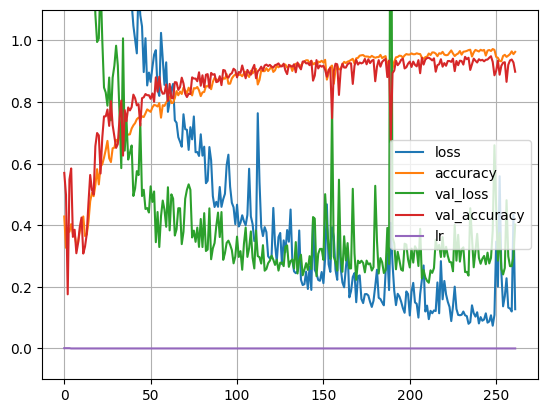

In [57]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1, 1.1)
plt.show()

In [11]:
model = tf.keras.models.load_model('checkpoint')
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 6ms/step - loss: 0.2774 - accuracy: 0.9256


[0.27737221121788025, 0.9256038665771484]

33/33 [==============================] - 0s 4ms/step


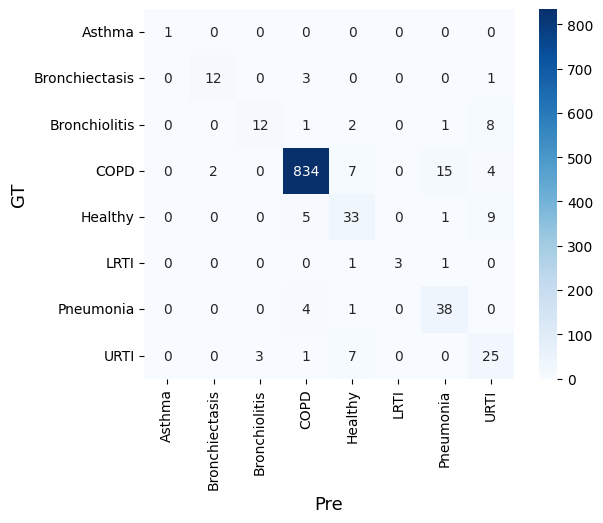

In [12]:
le = load('./label_encoder.joblib')
y_pred = model.predict(X_test)
classes = le.classes_
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
sns.heatmap(pd.DataFrame(cm, columns=classes, index=classes), cmap='Blues', annot=True, square=True, fmt='g')
plt.xlabel("Pre", fontsize=13)
plt.ylabel("GT", fontsize=13)
plt.show()

In [13]:
print(classification_report(y_test, y_pred.argmax(axis=1), target_names=classes))

                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00         1
Bronchiectasis       0.86      0.75      0.80        16
 Bronchiolitis       0.80      0.50      0.62        24
          COPD       0.98      0.97      0.98       862
       Healthy       0.65      0.69      0.67        48
          LRTI       1.00      0.60      0.75         5
     Pneumonia       0.68      0.88      0.77        43
          URTI       0.53      0.69      0.60        36

      accuracy                           0.93      1035
     macro avg       0.81      0.76      0.77      1035
  weighted avg       0.93      0.93      0.93      1035

